# Escaneamento de Imagem

- Dada uma imagem que estará fora de foco, a tarefa é restaurar a imagem para que a imagem fique nítida e se pareça com um scanner, que pode ser usado no OCR

In [2]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

In [3]:
def show_image(img):
    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Processamentos na imagem

1061 1049


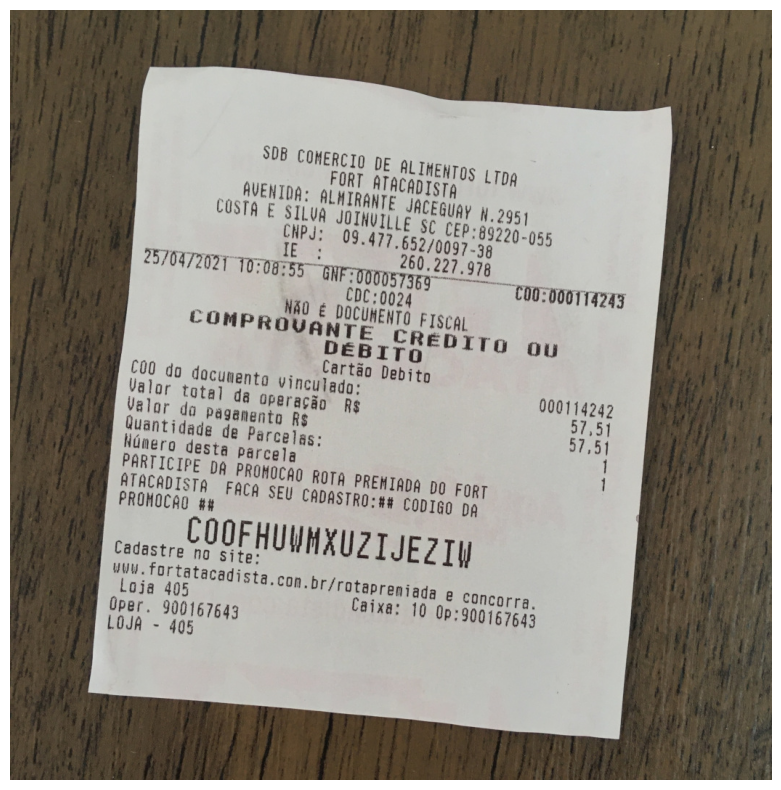

In [7]:
img = cv2.imread('imagens_projeto2/doc_rotacionado01.jpg')
original = img.copy()
(H, W) = img.shape[:2]
print(H, W) # dimensões da imagem
show_image(img)

## Converter para a escala de cinza

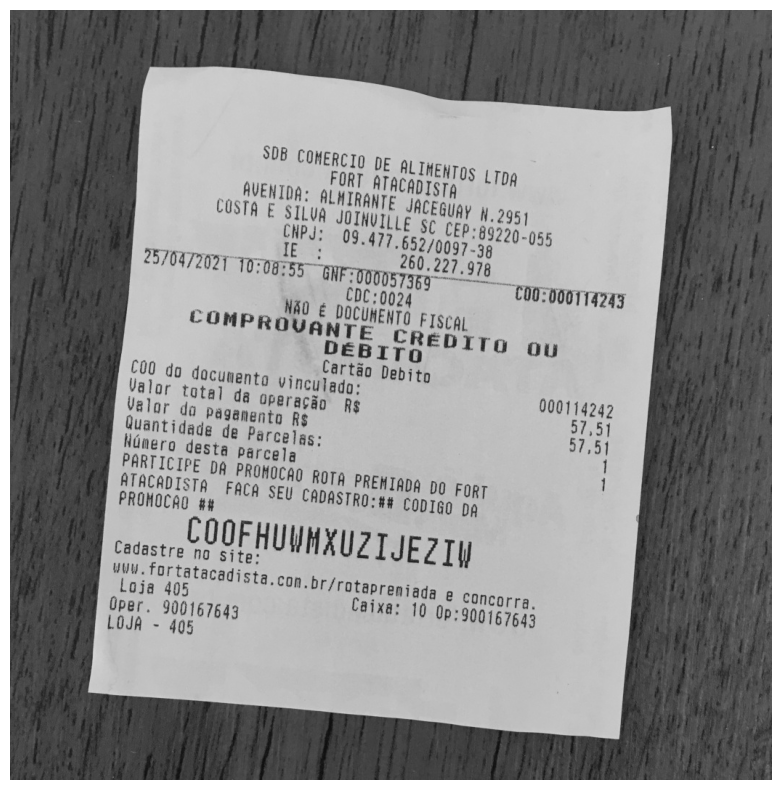

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)

## Aplicação de desfoque

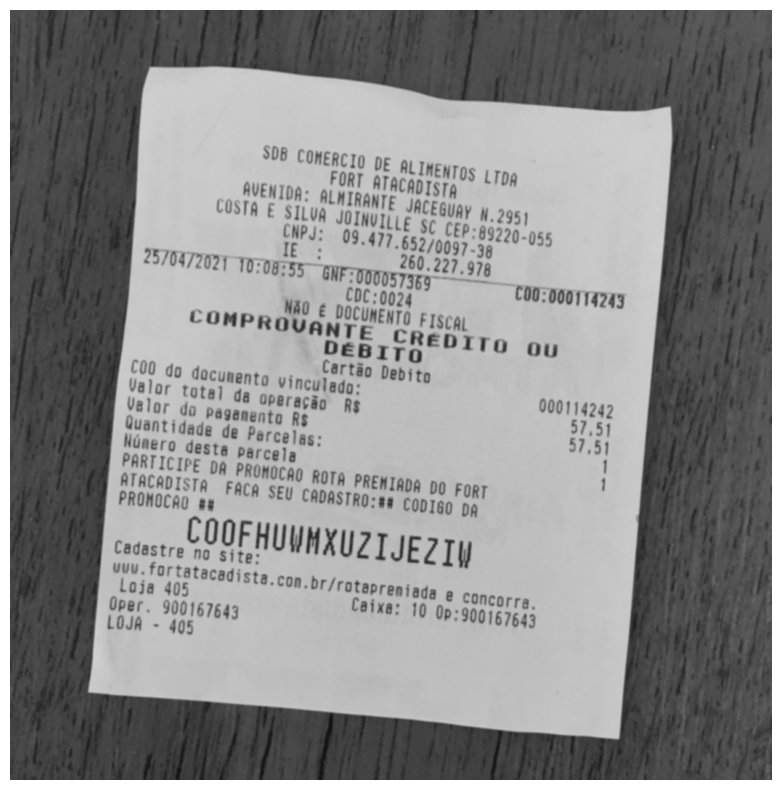

In [9]:
blur = cv2.GaussianBlur(
    src=gray, 
    ksize=(5, 5), 
    sigmaX=0
)

show_image(blur)

## Detecção de bordas

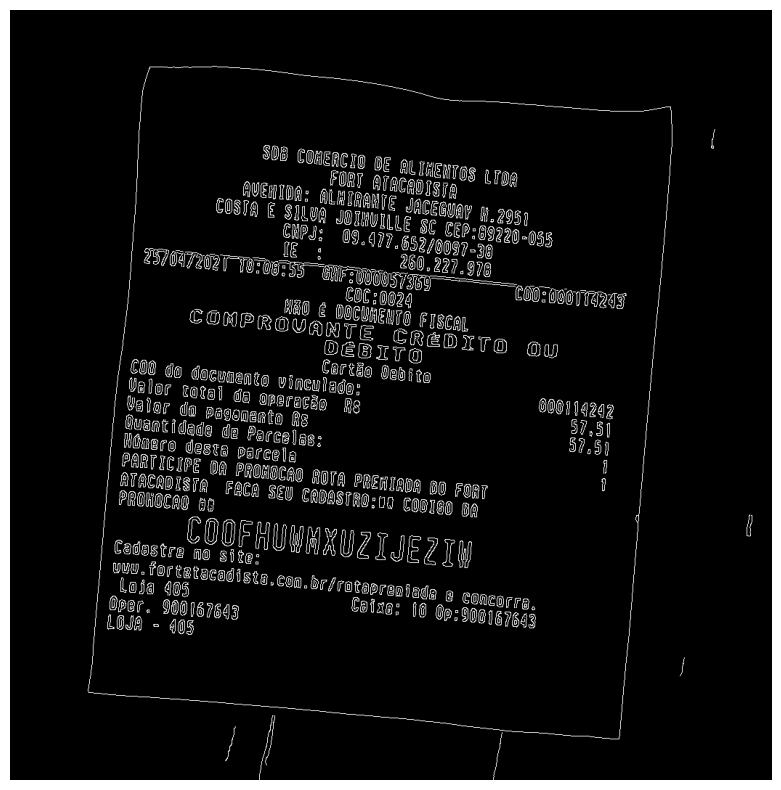

In [11]:
edged = cv2.Canny(
    image=blur, 
    threshold1=60, 
    threshold2=160
)
show_image(edged)

## Detecção de contornos na imagem

In [12]:
def find_edge(img):
    cnts = cv2.findContours(
        image=img.copy(), 
        mode=cv2.RETR_EXTERNAL,
        method=cv2.CHAIN_APPROX_SIMPLE
    )
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:6]
    return cnts

In [13]:
conts = find_edge(edged.copy())

## Encontrando o maior contorno

In [15]:
for c in conts:
    perimeter = cv2.arcLength(curve=c, closed=True)
    approx = cv2.approxPolyDP(curve=c, epsilon=0.02 * perimeter, closed=True)

    if len(approx) == 4:
        maior = approx
        break

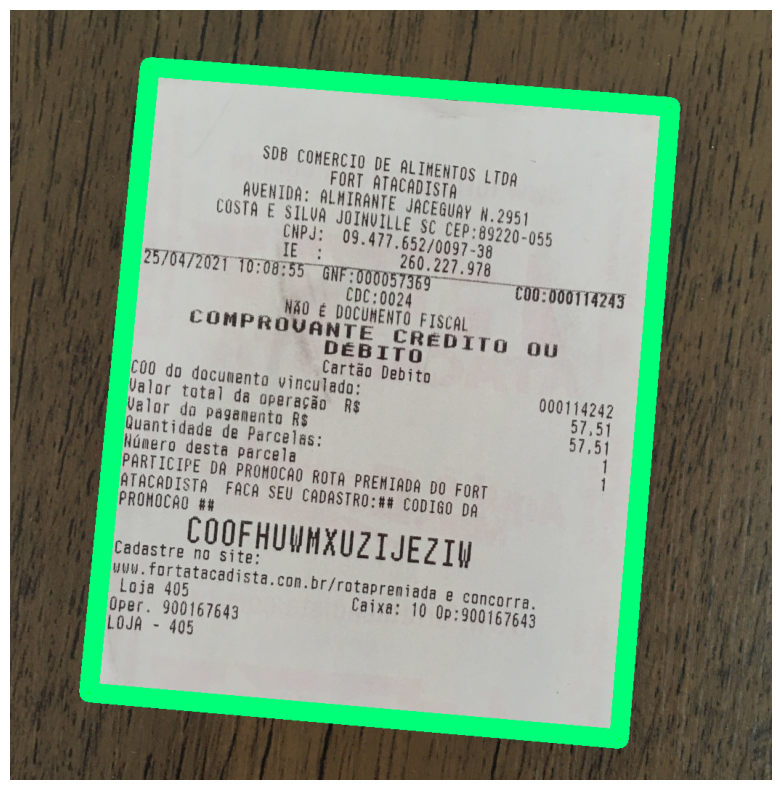

In [21]:
cv2.drawContours(
    image=img, 
    contours=maior, #[maior]
    contourIdx=-1, 
    color=(0, 255, 0), 
    thickness=2
)

show_image(img)

## Ordenando os pontos do contorno

In [22]:
def order_points(points):
    points = points.reshape((4, 2))
    new_points = np.zeros((4, 1, 2), dtype=np.int32)

    add = points.sum(1)
    new_points[0] = points[np.argmin(add)]
    new_points[2] = points[np.argmax(add)]

    diff = np.diff(points, axis=1)
    new_points[1] = points[np.argmin(diff)]
    new_points[3] = points[np.argmax(diff)]

    return new_points

In [23]:
pontos_maior = order_points(maior)
print(pontos_maior)

[[[ 192   78]]

 [[ 909  133]]

 [[ 838 1004]]

 [[ 108  940]]]


## Obtenção da matriz de transformação

In [24]:
pts1 = np.float32(pontos_maior)
pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

In [25]:
matrix = cv2.getPerspectiveTransform(pts1, pts2)

In [26]:
matrix

array([[ 1.47103022e+00,  1.43348652e-01, -2.93618997e+02],
       [-9.58731834e-02,  1.24983768e+00, -7.90796880e+01],
       [ 1.08773828e-05,  2.32288006e-05,  1.00000000e+00]])

## Transformação da imagem

In [27]:
transform = cv2.warpPerspective(
    src=original, 
    M=matrix, 
    dsize=(W, H)
)

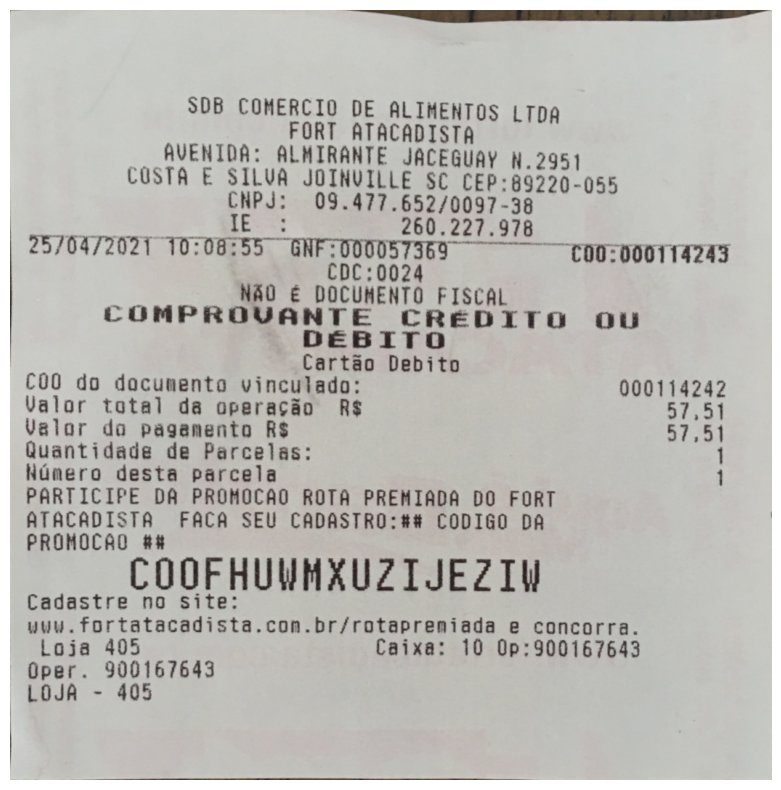

In [28]:
show_image(transform)

## OCR com Tesseract

In [29]:
import pytesseract

In [30]:
config_tesseract = "--tessdata-dir ../tessdata"

In [31]:
texto = pytesseract.image_to_string(
    image=transform, 
    lang="por",
    config=config_tesseract
)

In [33]:
print(texto)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
AVENIDA: ALMIRANTE JACEGUAY N.2951
COSTA E SILVA JOINUILLE SC CEP:89220-055
CNPJ: 09.477.652/0097-38
7 SRAm 260.227.978

2570972027 T0:08:55" Gnrzggvgãzgsà““““'** ***** CO0T0001142A3

NÃO É DOCUMENTO FISCAL
COMPROUANTE CREDITO OU

DÉBIT

Cartão Debito
COO do documento vinculado: 000114242
Valor total da operação R$ 55l
Valor do pagamento R$ BTAA
Quantidade de Parcelas:
Núnmnero desta parcela 1

PARTICIFE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:%% CODIGO DA
PROMOCAO &%

COOFHUWMXUZIJEZIV

Cadastre no site:
uuu.fortatacadista.con.br/rotapreniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405

 



## Aumentando brilho e contraste

In [36]:
brilho = 50
contraste = 50
ajustes = np.int16(transform)
ajustes.shape

(1061, 1049, 3)

In [37]:
ajustes = ajustes * (contraste/127 + 1) - contraste + brilho

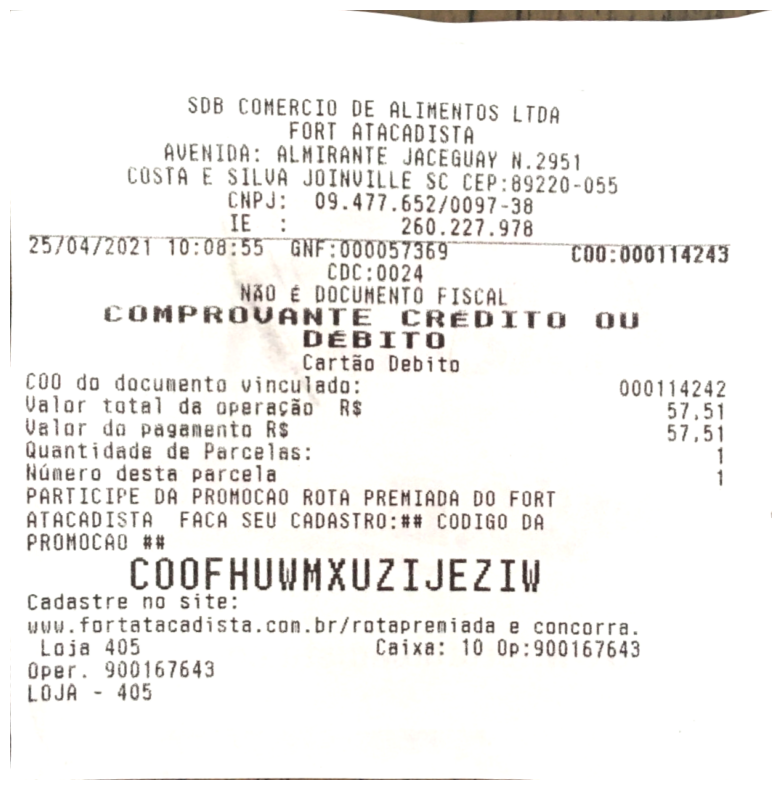

In [39]:
ajustes = np.clip(ajustes, 0, 255)
ajustes = np.uint8(ajustes)
show_image(ajustes)

## Limiarização

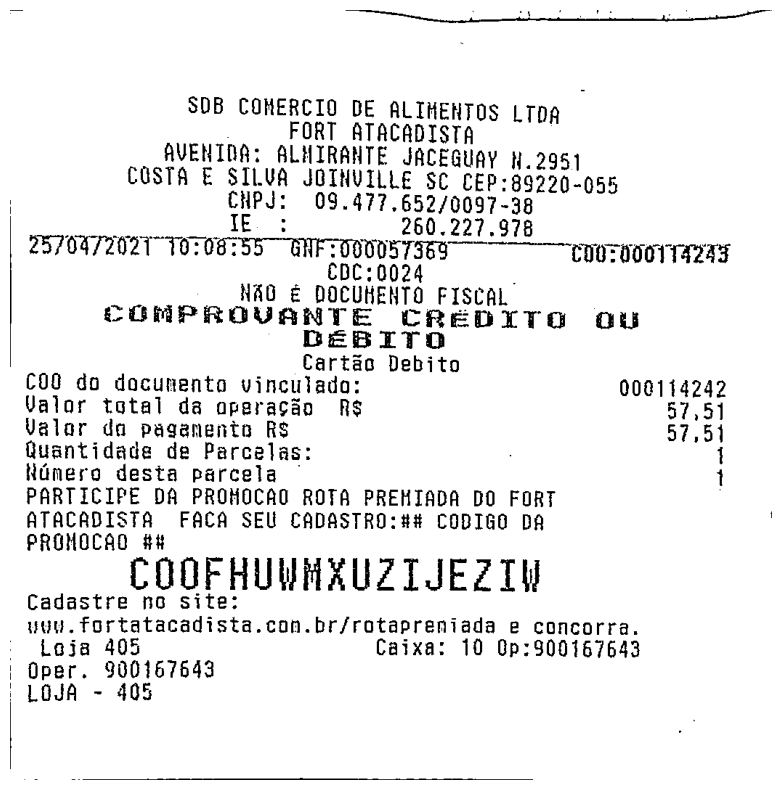

In [40]:
img_process = cv2.cvtColor(
    src=transform,
    code=cv2.COLOR_BGR2GRAY
)

img_process = cv2.adaptiveThreshold(
    src=img_process,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=11,
    C=9
)

show_image(img_process)

## Remoção de bordas

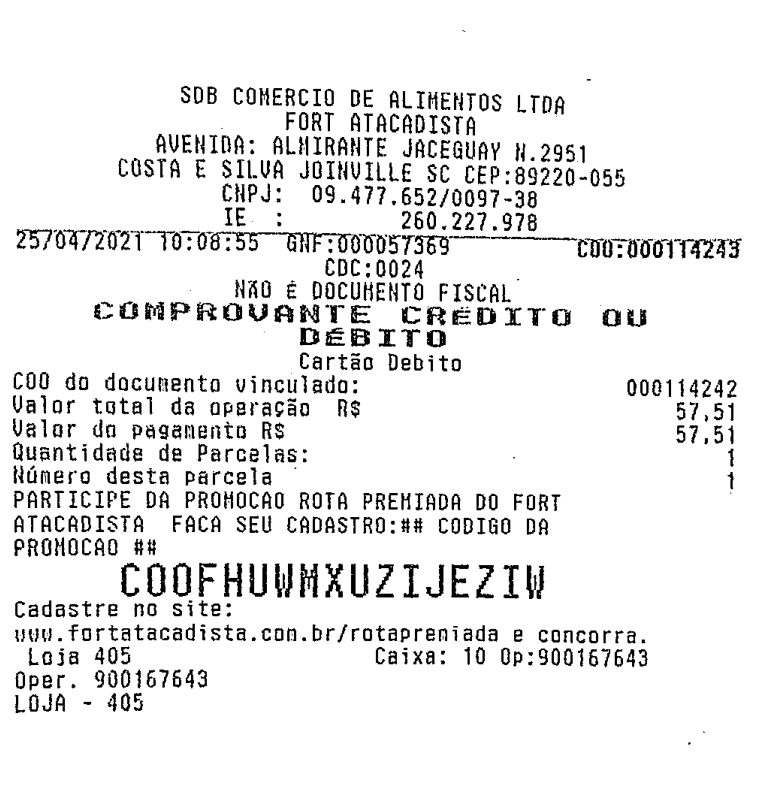

In [41]:
margem = 18
img_final = img_process[margem:H-margem, margem:W-margem]
show_image(img_final)

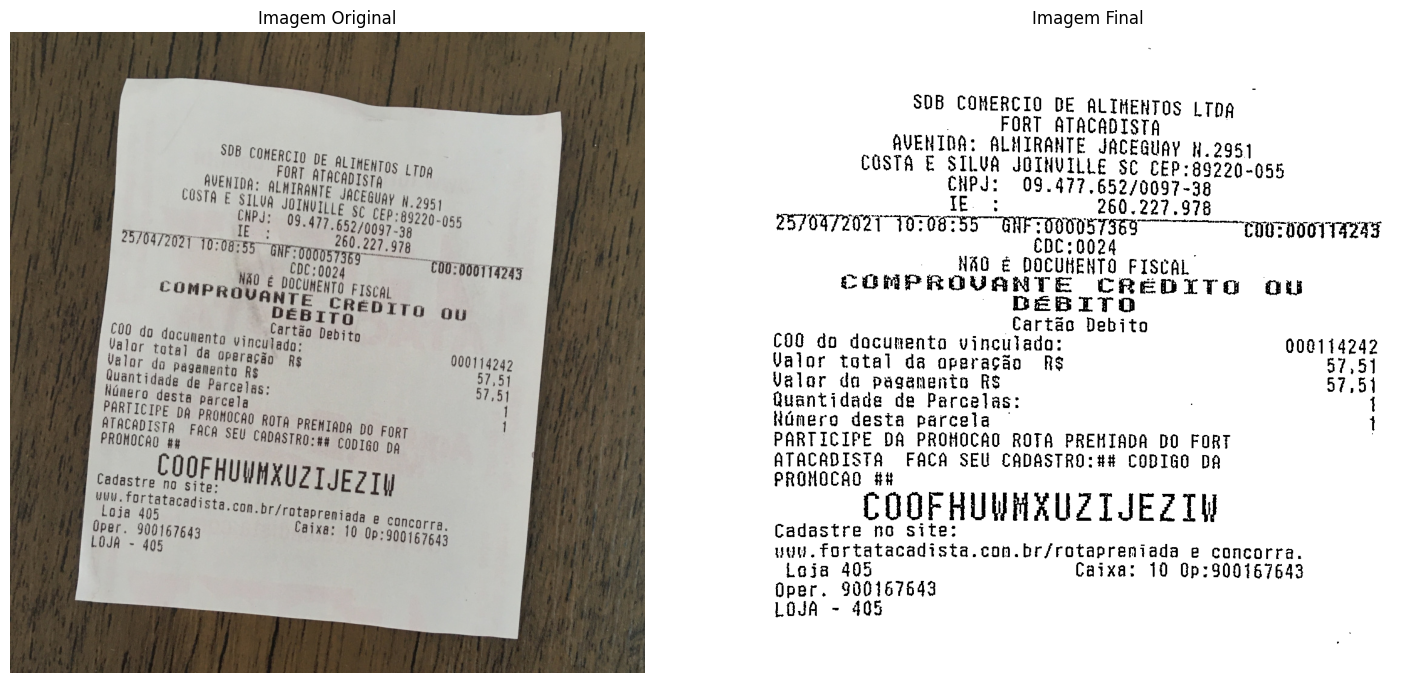

In [43]:
# comparando as duas imagens

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
axs[0].set_title('Imagem Original')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
axs[1].set_title('Imagem Final')
axs[1].axis('off')
plt.show()